In [27]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from dc_vae import DCVAE, Sampling
from utils import samples_conditions_embedd

In [77]:
files

['/home/gastong/Documentos/TELCO/v0/TELCO_data_2022_01.zip',
 '/home/gastong/Documentos/TELCO/v0/TELCO_data_2022_02.zip',
 '/home/gastong/Documentos/TELCO/v0/TELCO_data_2022_03.zip',
 '/home/gastong/Documentos/TELCO/v0/TELCO_data_2022_04.zip']

In [68]:
settings_path = 'settings/model_settings.txt'
settings = json.load(open(settings_path, 'r'))
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v0/" #Rosaluna
filenames = ["TELCO_data_2022_01.zip", "TELCO_data_2022_02.zip", "TELCO_data_2022_03.zip", "TELCO_data_2022_04.zip"]
files = [path+ i for i in filenames]
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 128, 'M': 12, 'cnn_units': [64, 64, 64, 64, 64, 64, 64], 'dil_rate': [1, 2, 4, 8, 16, 32, 64], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 32, 'J': 4, 'epochs': 100, 'lr': 0.0001, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'seed': 123, 'summary': True, 'custom_metrics': True}


In [81]:
# Load data and predictions
# Read CSV files from List
data = pd.concat(map(pd.read_csv, files))
data = set_index(data)
data = preprocessing(data, flag_scaler=False, outliers=True)
data

TS1       TS2       TS3       TS4       TS5  \
time                                                                    
2022-01-01 00:00:00  0.950918  0.331853  1.044191  1.080015  0.478342   
2022-01-01 00:05:00  0.953790  0.308883  1.044191  1.018991  0.333611   
2022-01-01 00:10:00  0.771174  0.242527  1.190647  0.863153  0.548832   
2022-01-01 00:15:00  0.612978  0.213496  1.190647  1.074681  0.298016   
2022-01-01 00:20:00  0.830040  0.138526  0.392594  0.931433  0.140246   
...                       ...       ...       ...       ...       ...   
2022-04-30 23:35:00  0.352983 -0.074581  0.506275  1.533222  0.487076   
2022-04-30 23:40:00  0.180603 -0.022261  1.169986  2.465266  0.307368   
2022-04-30 23:45:00  0.117753 -0.161036  1.169986  2.027793 -0.209240   
2022-04-30 23:50:00 -0.105269 -0.159760  0.121077  1.728893  0.513092   
2022-04-30 23:55:00  0.262339 -0.153379  0.121077  1.384388 -0.324699   

                          TS6       TS7       TS8       TS9      TS10  \
time                                                                    
2022-01-01 00:00:00  0.234028  0.696214  0.714023  0.004377  1.603301   
2022-01-01 00:05:00 -0.095064  0.557168  0.445282  0.004377  1.603301   
2022-01-01 00:10:00 -0.031327  0.422607  0.250676  0.004377  1.603301   
2022-01-01 00:15:00 -0.175711  0.448379  0.259943 -0.405597  0.545695   
2022-01-01 00:20:00 -0.234245  0.688942  0.463816 -0.405597  0.545695   
...                       ...       ...       ...       ...       ...   
2022-04-30 23:35:00  0.141674  0.561459  0.334079  1.553126  2.308372   
2022-04-30 23:40:00 -0.041733  0.320081  0.185808  1.553126  2.308372   
2022-04-30 23:45:00 -0.092462  0.525684  0.287744 -0.049580  1.074498   
2022-04-30 23:50:00 -0.062545  0.304816  0.056071 -0.049580  1.074498   
2022-04-30 23:55:00 -0.078154  0.302695  0.037537 -0.049580  1.074498   

                         TS11      TS12  
time                                     
2022-01-01 00:00:00 -0.674944 -0.701202  
2022-01-01 00:05:00 -0.674944 -0.701202  
2022-01-01 00:10:00 -0.674944 -0.701202  
2022-01-01 00:15:00 -0.699482 -0.720646  
2022-01-01 00:20:00 -0.699482 -0.720646  
...                       ...       ...  
2022-04-30 23:35:00 -0.468192 -0.497042  
2022-04-30 23:40:00 -0.468192 -0.497042  
2022-04-30 23:45:00 -0.388861 -0.428989  
2022-04-30 23:50:00 -0.388861 -0.428989  
2022-04-30 23:55:00 -0.388861 -0.428989  

[34560 rows x 12 columns]

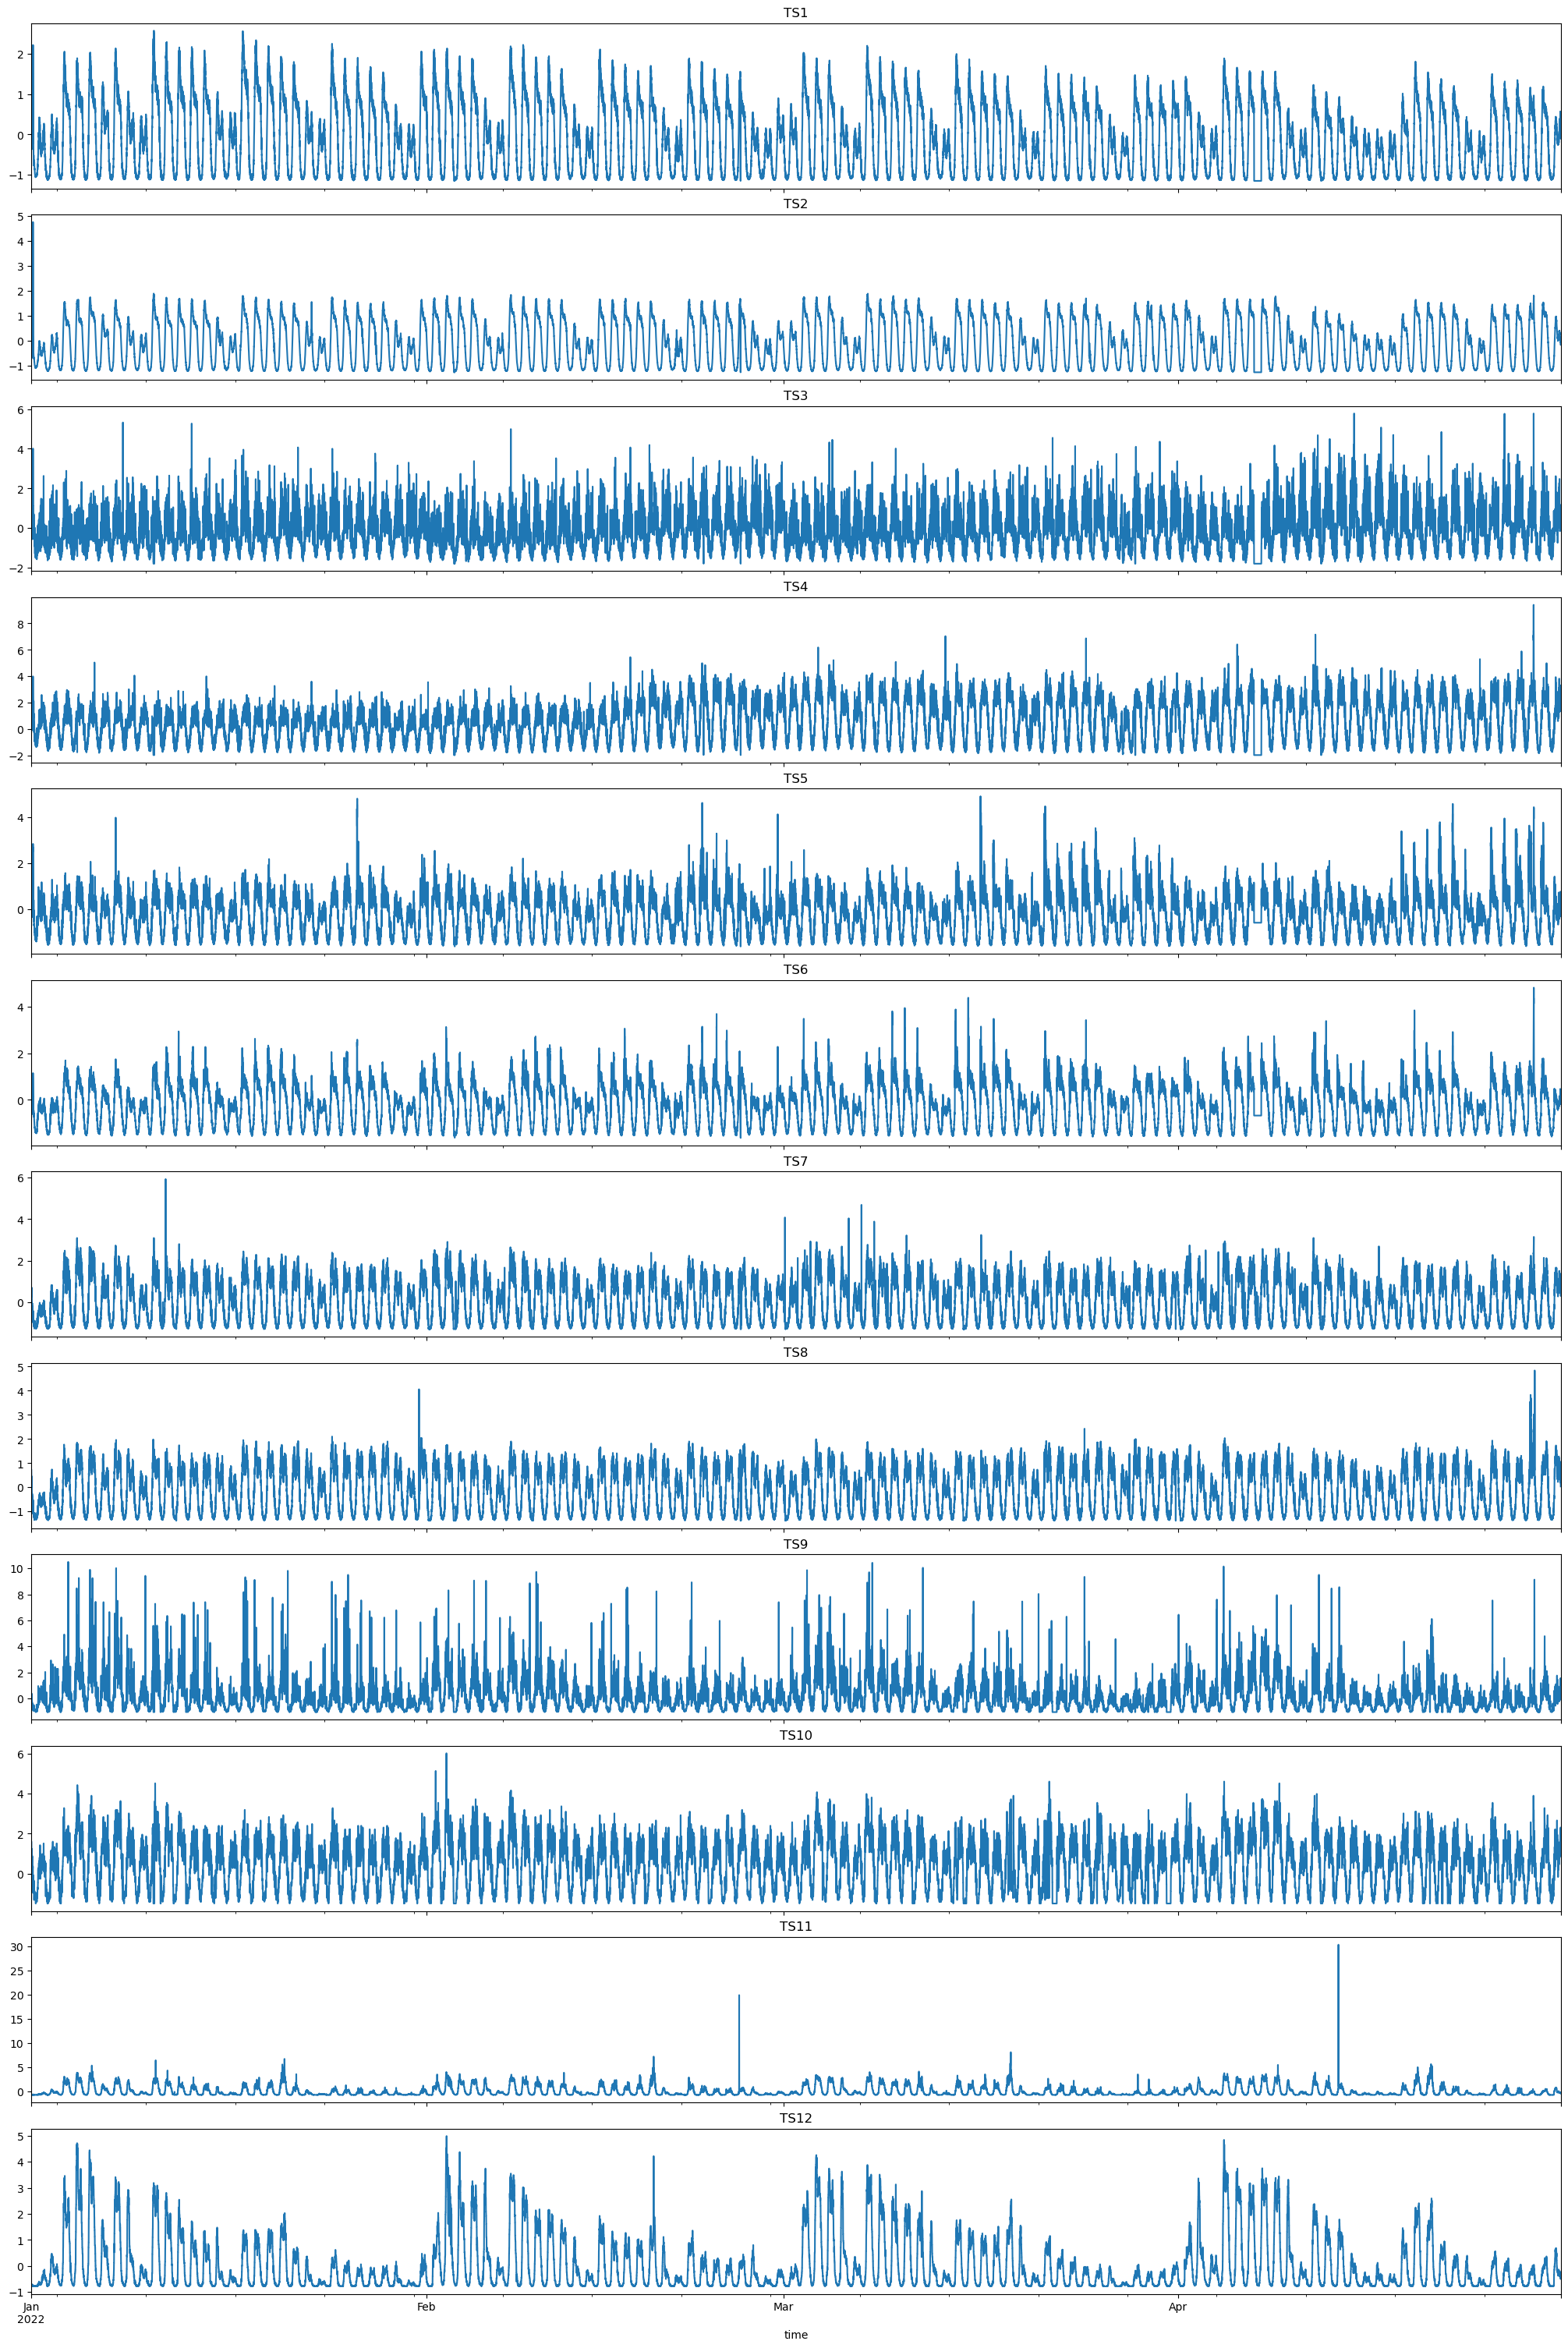

In [82]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data_aux.columns

time_start = '2022-01-01'
time_end = '2022-04-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

## Predicciones

In [70]:
    # Model initialization
model = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['epochs'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['model_name'],
    settings['summary']
    ) 

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input[0][0]                      
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 64)      8192        dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 64)      8192        dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [83]:
with tf.device('/cpu:0'):
    anom, error, reconst, sig, latent_space = model.predict(data,
                                            True,
                                            large_result=True,
                                            load_alpha=False,
                                            alpha_set_up = list(np.ones(12)),
                                            alpha_set_down = list(np.ones(12))
                                                        )

In [84]:
th_up = reconst + np.ones(12)*sig
th_down = reconst - np.ones(12)*sig

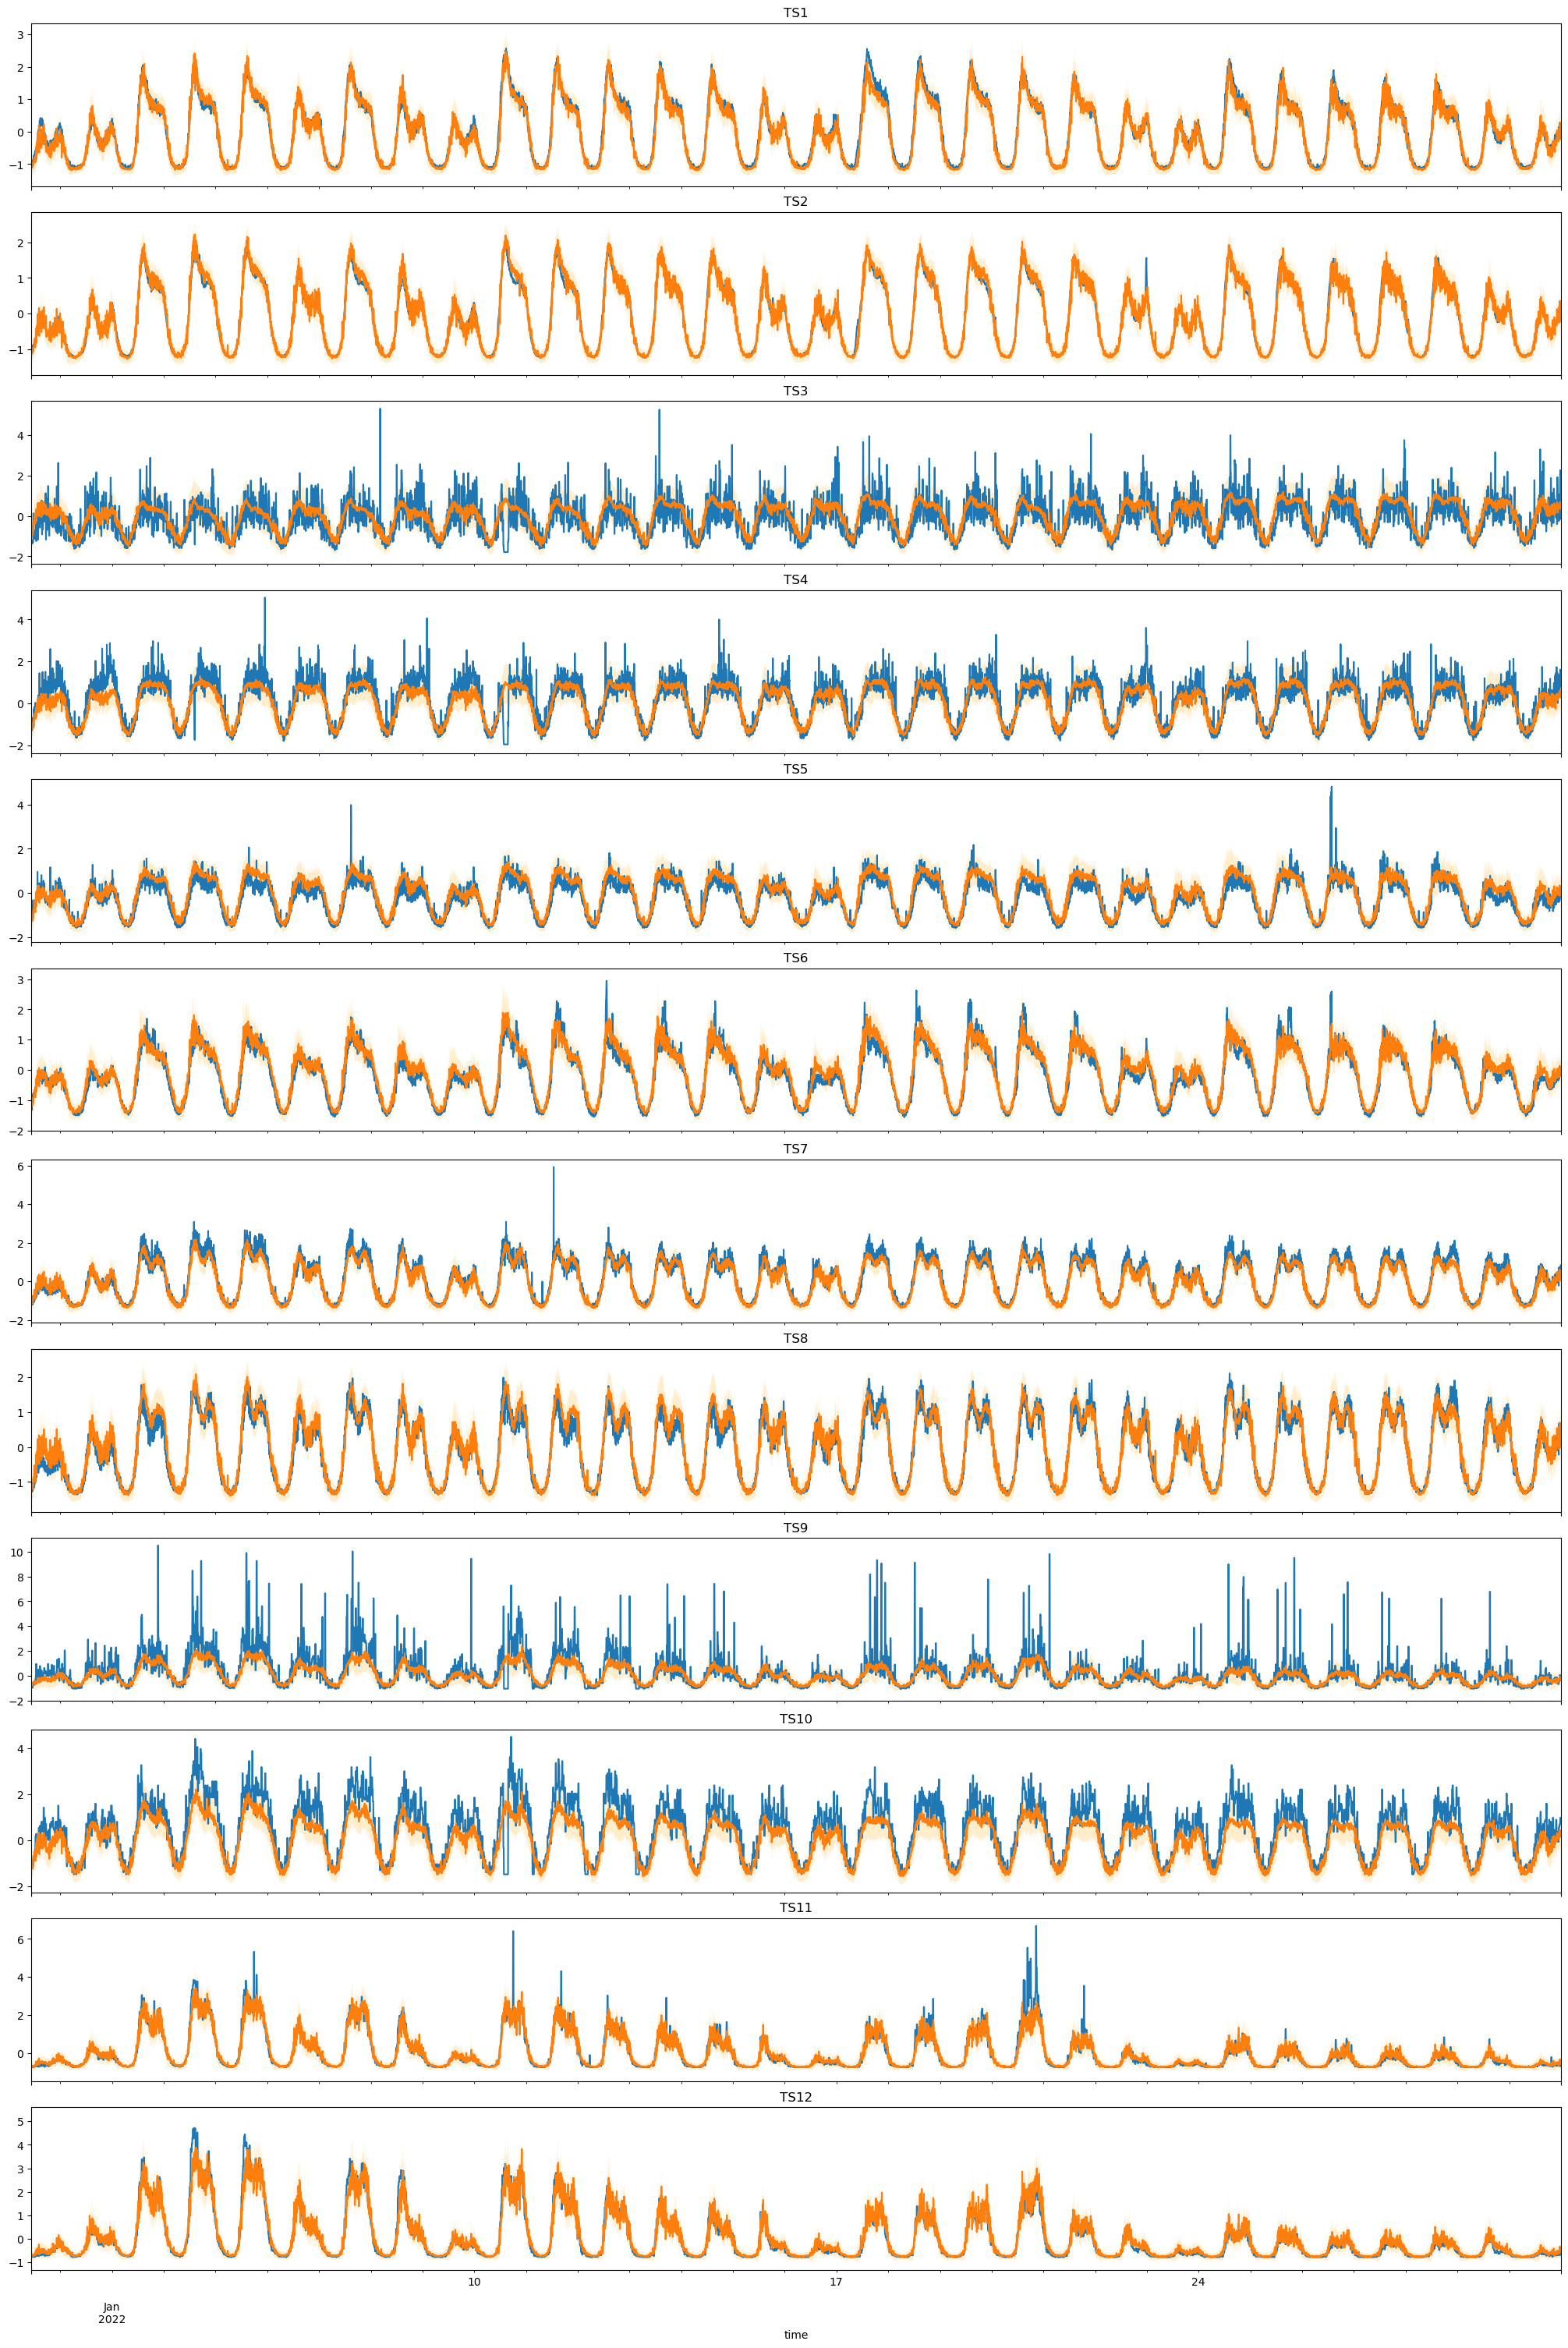

In [86]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data[reconst.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2022-01-01'
time_end = '2022-01-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up[columns_list[count]][time_start:time_end],
                         th_down[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.2, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1

<AxesSubplot:>

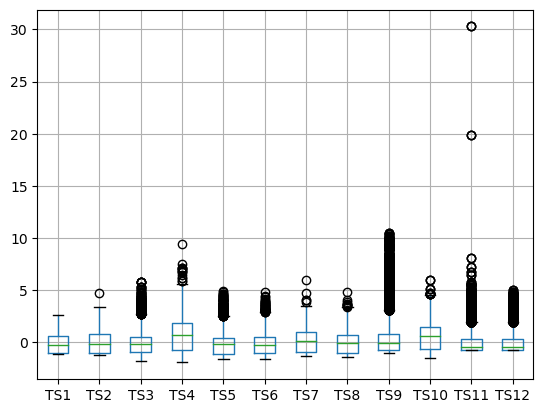

In [87]:
data[]

## Generación de datos

In [12]:
X = data.values
X = np.array([X[i: i + settings['T']] for i in range(0, X.shape[0] - settings['T']+1)])
with tf.device('/cpu:0'):
    z_mu, z_log_var, z = model.encoder.predict(X)

In [13]:
z_t = z[:,-1,:]

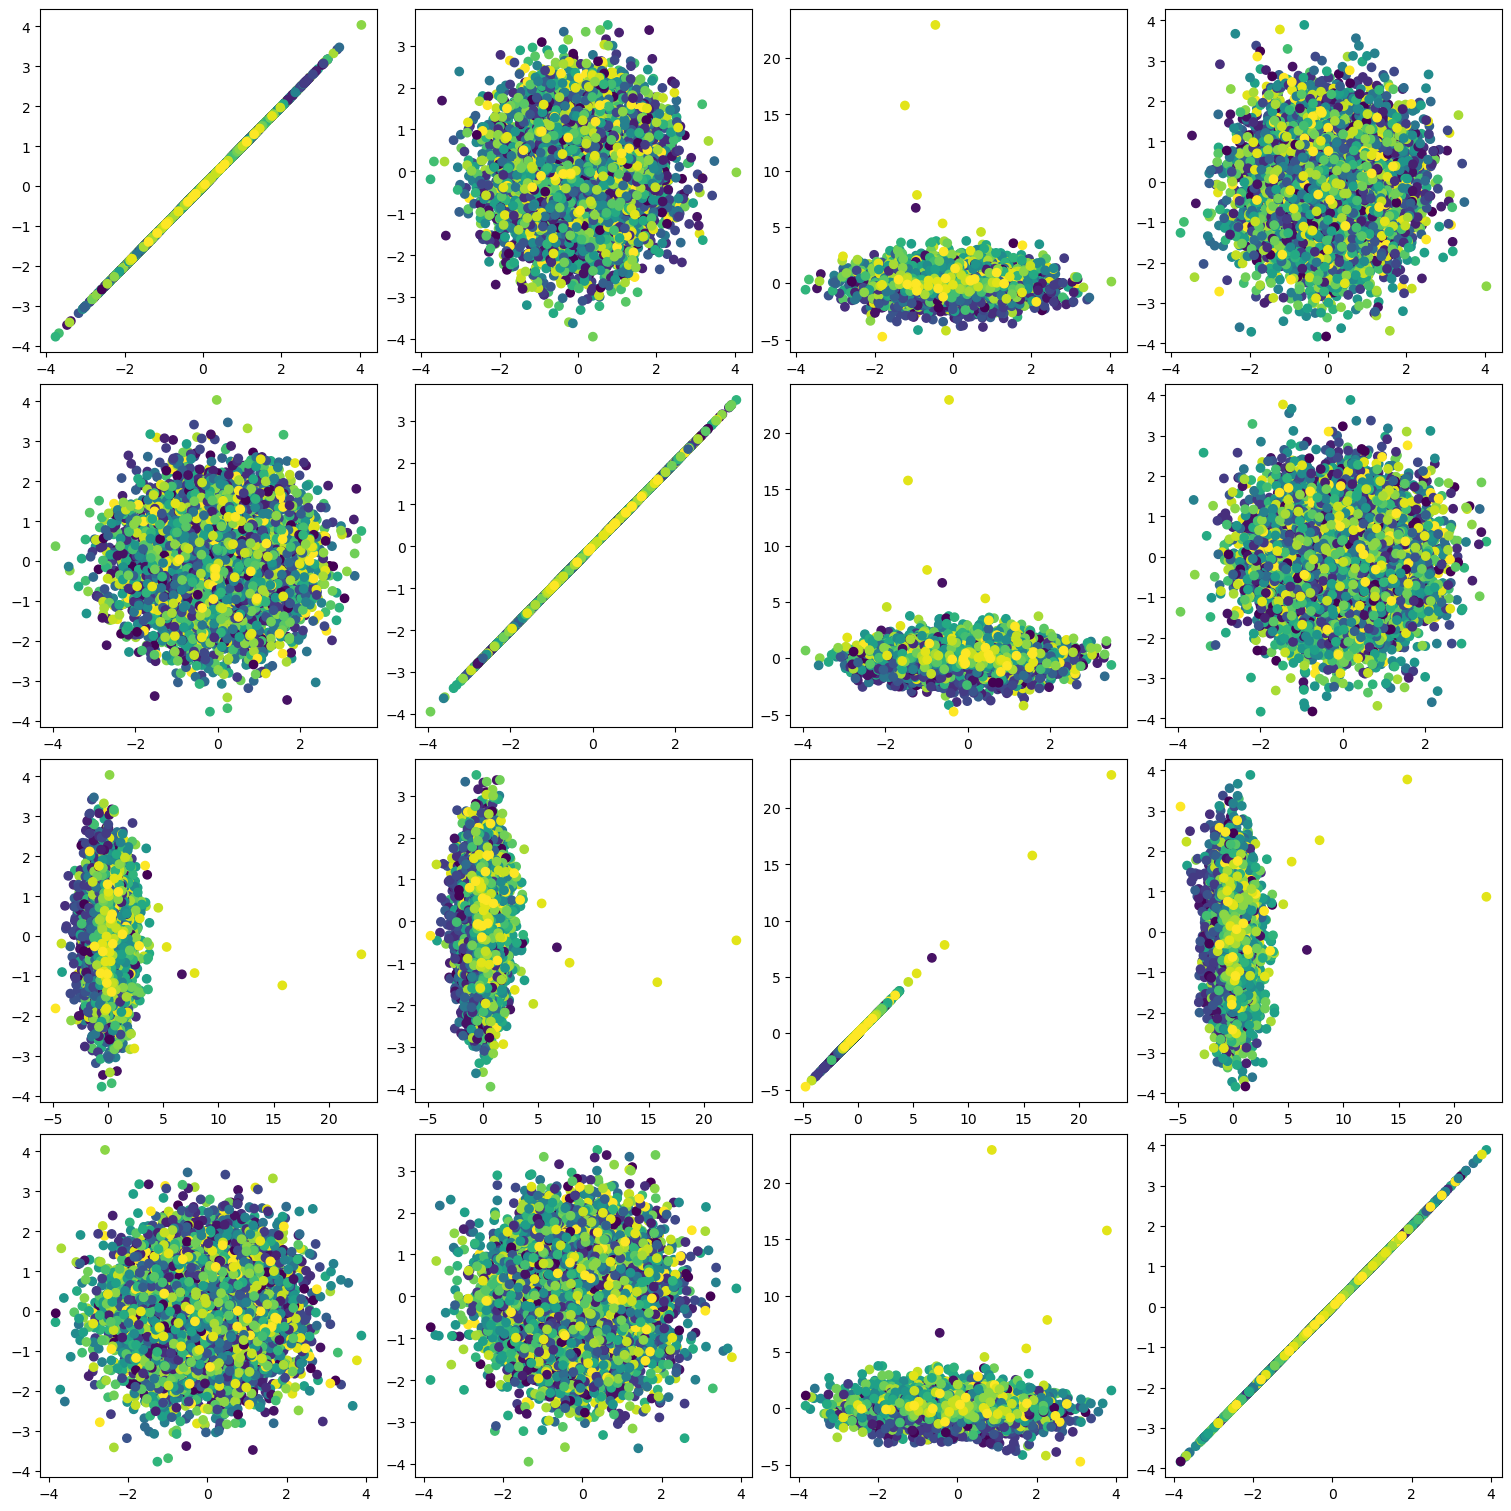

In [14]:
fig, axes = plt.subplots(settings['J'], settings['J'], figsize=(15,15), constrained_layout=True)

for i in range(settings['J']):
    for j in range(settings['J']):
        axes[i,j].scatter(z_t[:, i], z_t[:, j], c=data.index.hour[model.T-1:])

In [61]:
noise = np.random.normal(0, 1, (X.shape[0], settings['T'], settings['J']))
print(noise.shape)

(8513, 128, 4)


In [63]:
mu_gen.shape

(8513, 128, 12)

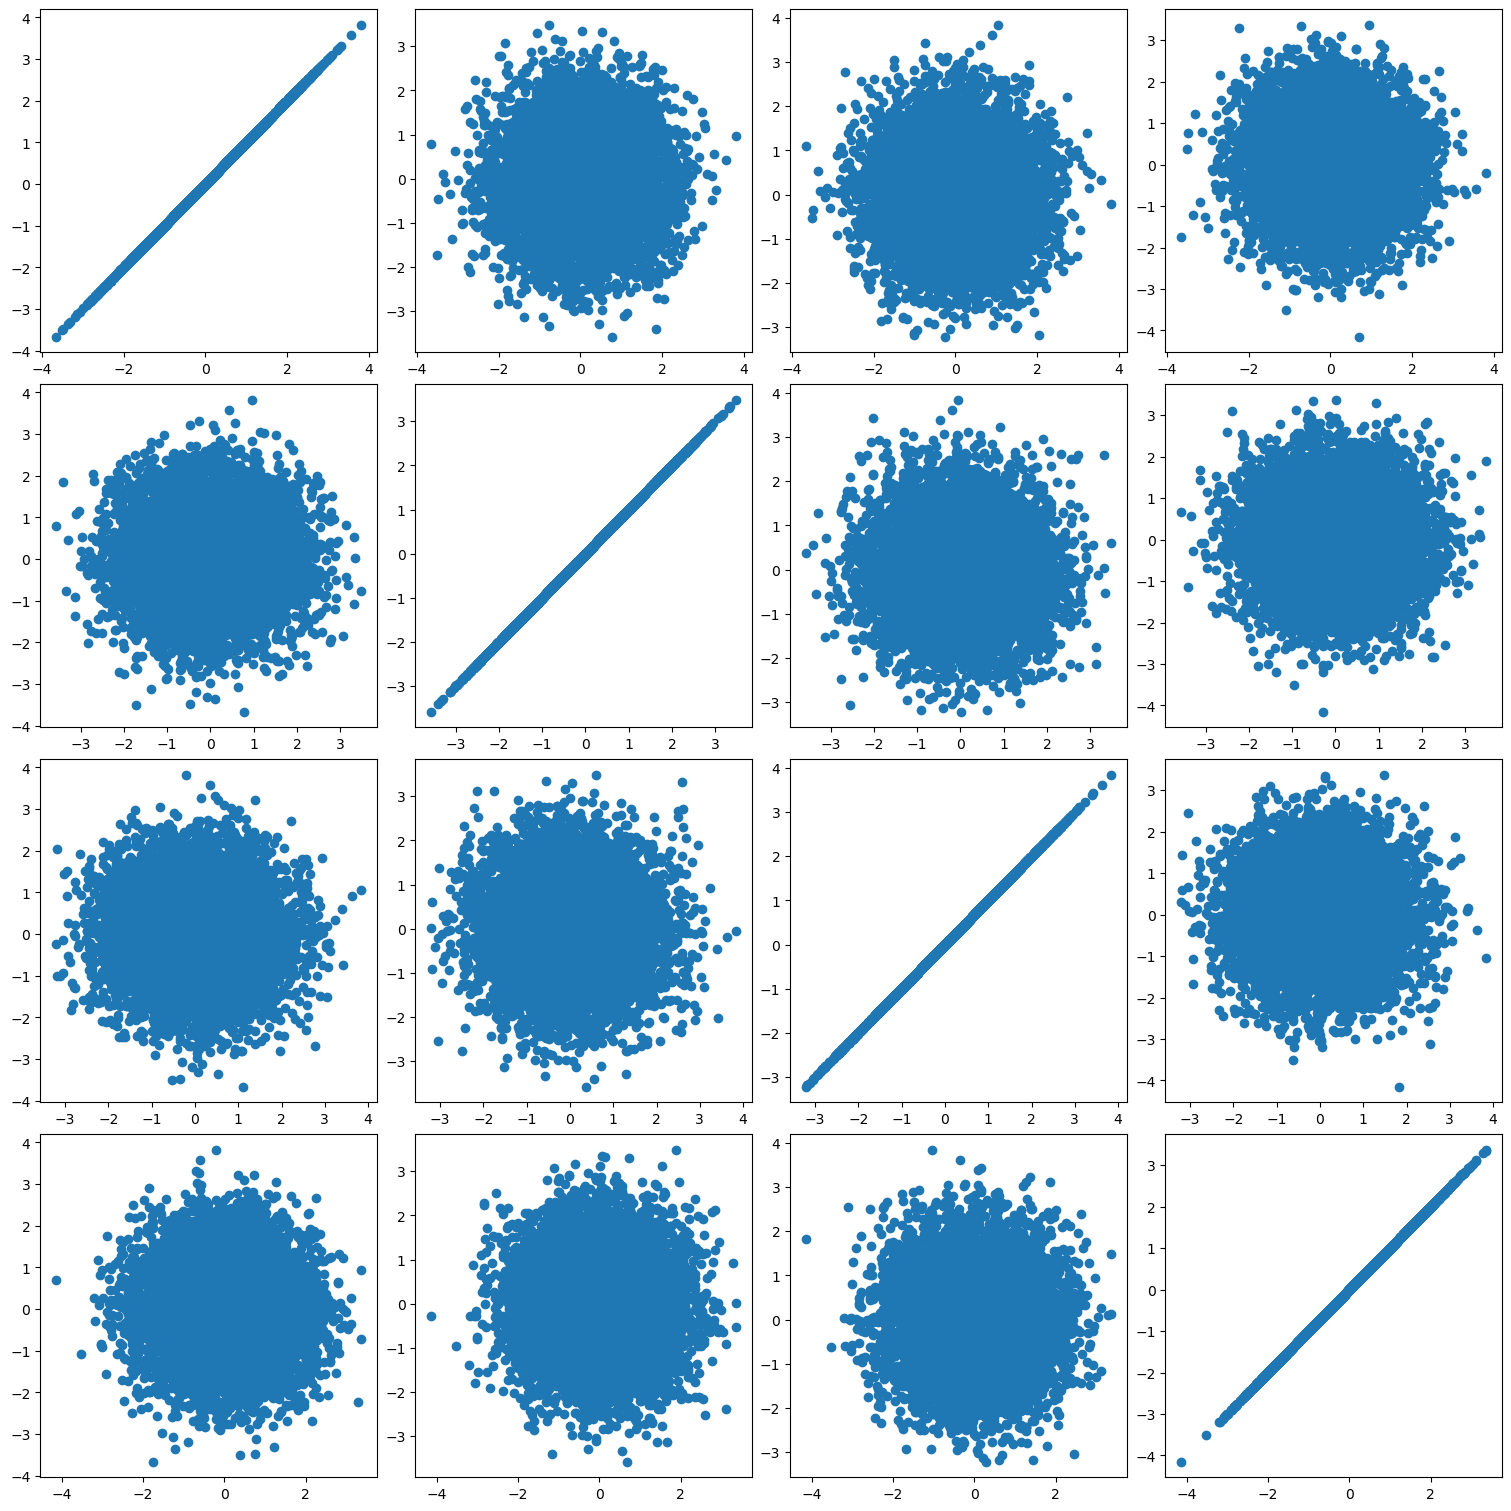

In [21]:
fig, axes = plt.subplots(settings['J'], settings['J'], figsize=(15,15), constrained_layout=True)

for i in range(settings['J']):
    for j in range(settings['J']):
        axes[i,j].scatter(noise[:, -1, i], noise[:, -1, j])

In [29]:
with tf.device('/cpu:0'):

    decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
                                                custom_objects={'sampling': Sampling},
                                                compile = False)

In [54]:
with tf.device('/cpu:0'):
    mu_gen, log_var_gen = decoder.predict(noise)

In [55]:
sig_gen = np.sqrt(np.exp(log_var_gen))

In [65]:
noise2gen = np.random.normal(0, 1, (X.shape[0], settings['T'], settings['M']))

X_gen = mu_gen + noise2gen*sig_gen

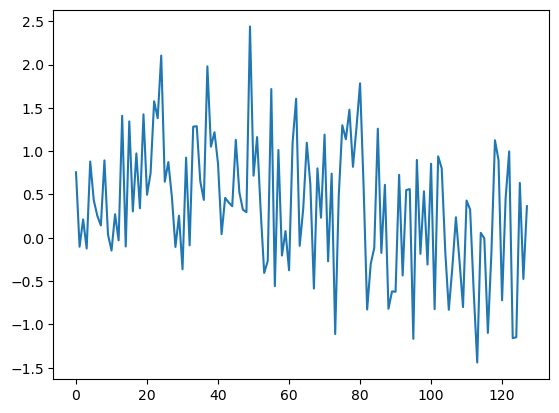

In [66]:
plt.plot(X_gen[0,:,3])

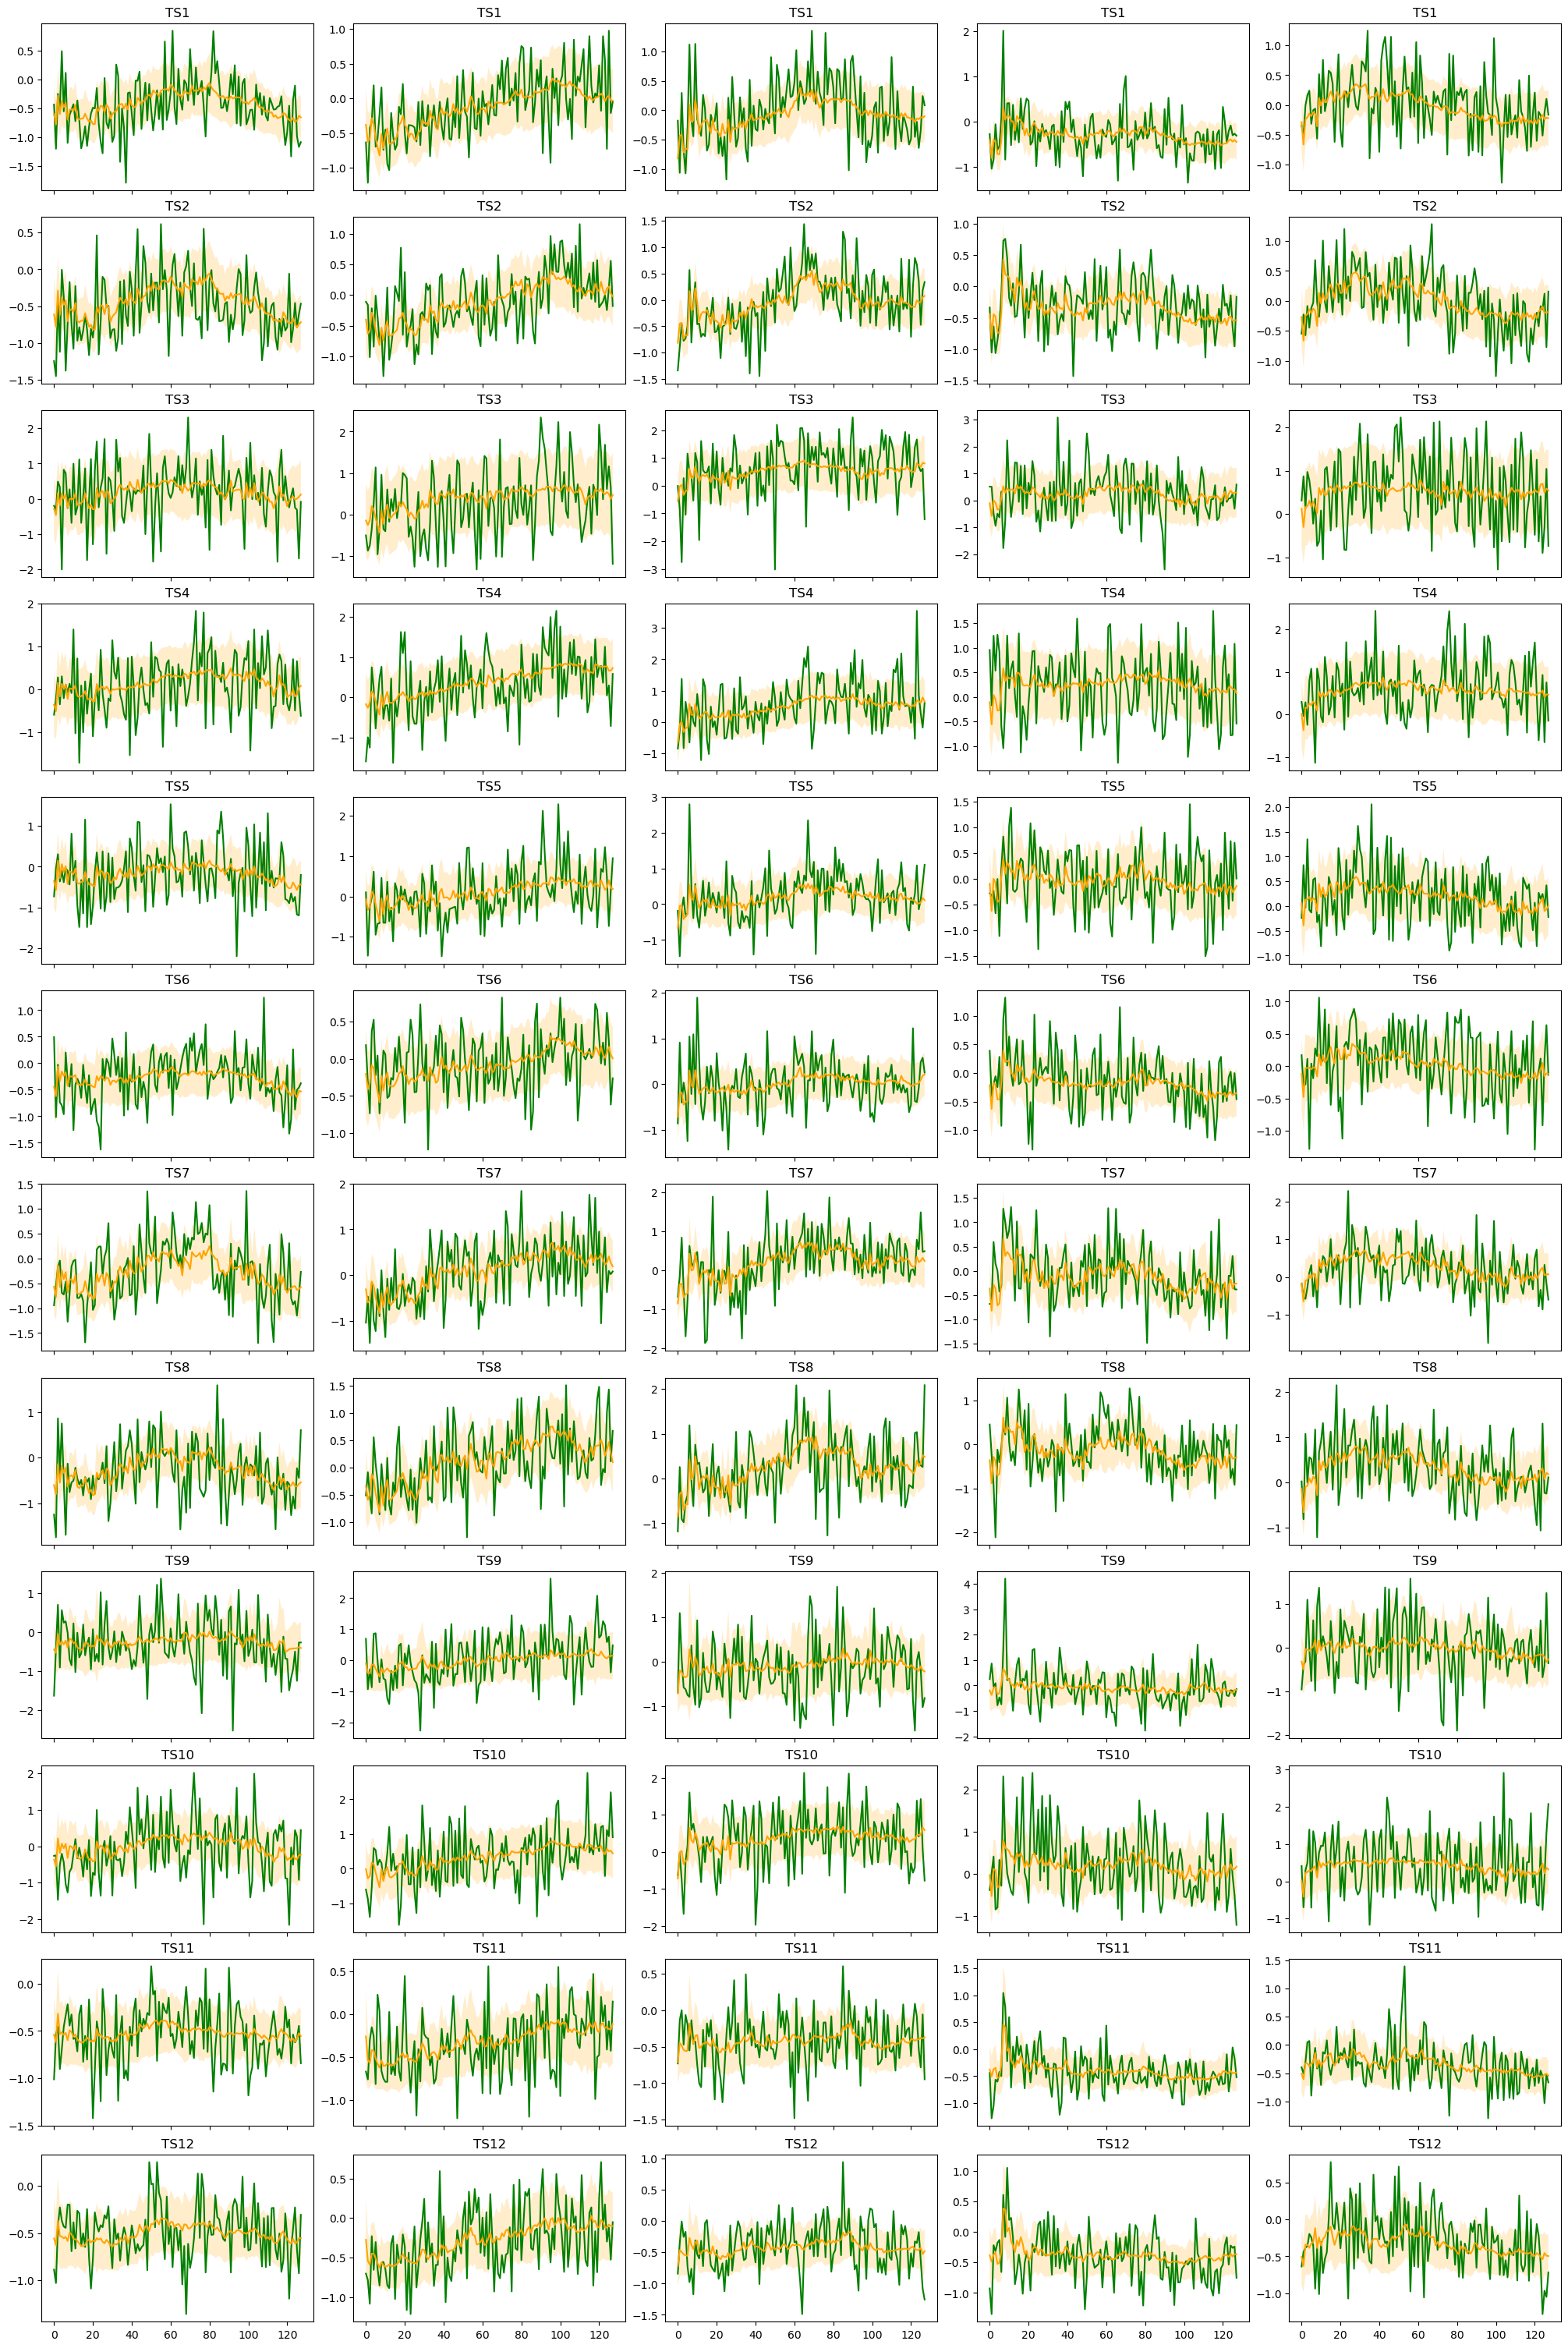

In [67]:
#define number of rows and columns for subplots
nrow=12
ncol=5

offset = 100

columns_list = data_aux.columns

fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        axes[r, c].plot(X_gen[c+offset,:,r], c='green')
        axes[r, c].plot(mu_gen[c+offset,:,r], c='orange')
        axes[r, c].fill_between(np.arange(settings['T']),
                         mu_gen[c+offset,:,r] + sig_gen[c+offset,:,r],
                         mu_gen[c+offset,:,r] - sig_gen[c+offset,:,r],
                         facecolor='orange', alpha=0.2, interpolate=True)
        axes[r, c].set_title(columns_list[r])
        count+=1

In [ ]:
df_mu_gen = pd.DataFrame(mu_gen[:, -1, :], index=reconst_cd.index, columns=reconst_cd.columns)
df_sig_gen = pd.DataFrame(sig_gen[:, -1, :], index=reconst_cd.index, columns=reconst_cd.columns)

In [ ]:
th_up_gen = df_mu_gen + np.ones(12)*df_sig_gen
th_down_gen = df_mu_gen - np.ones(12)*df_sig_gen

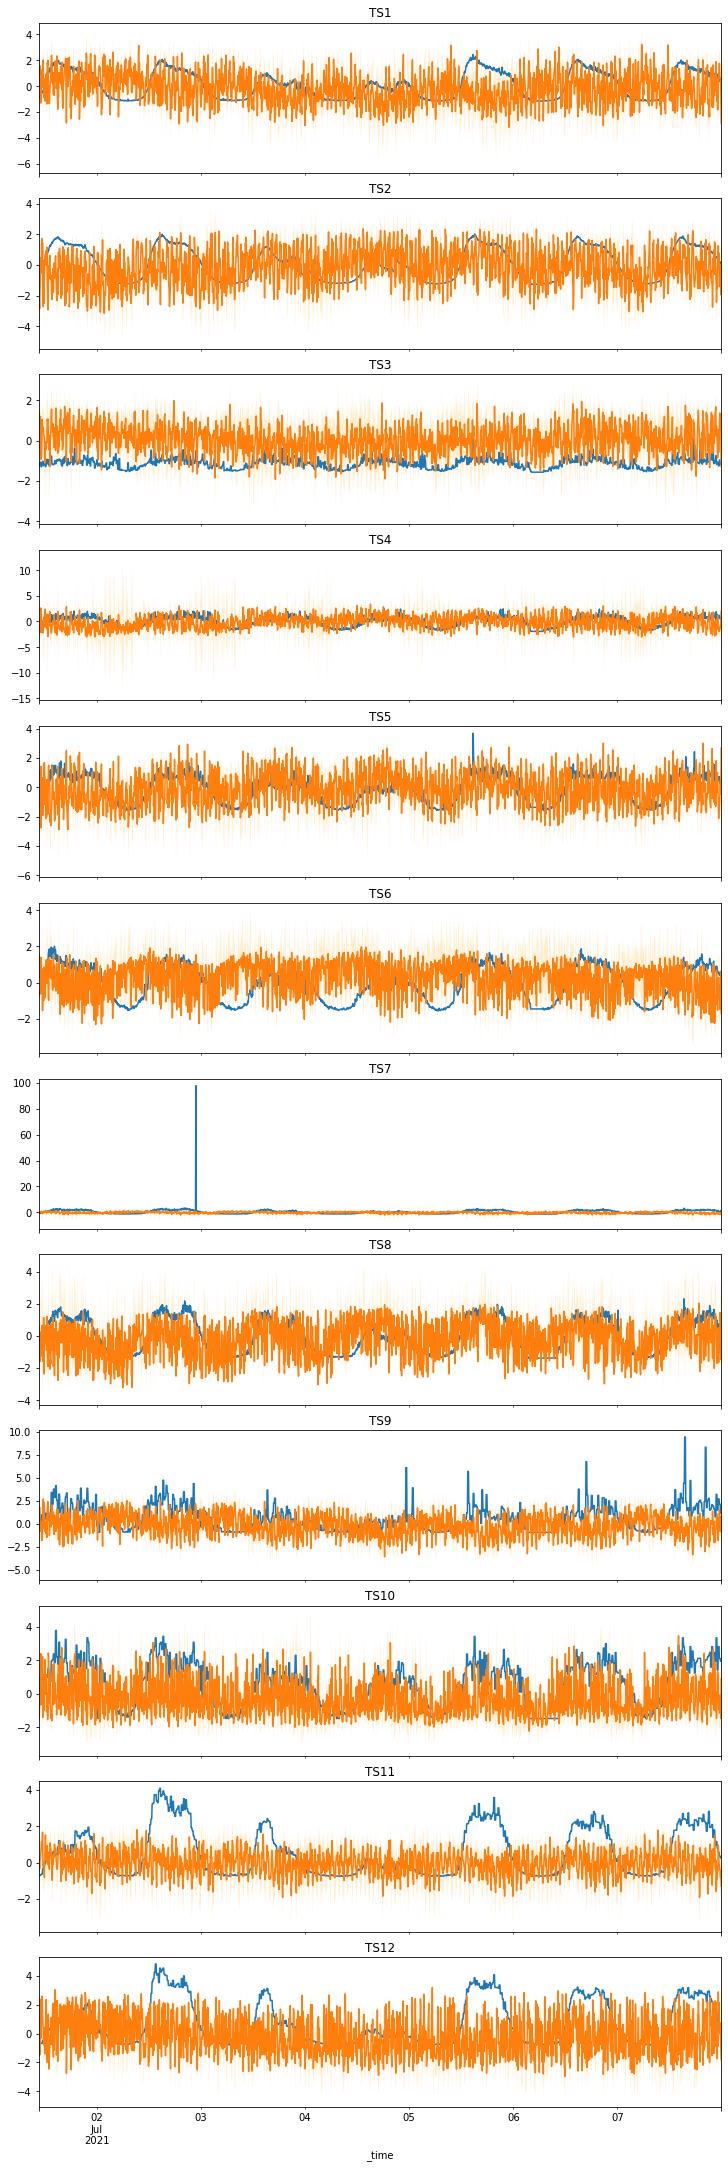

In [ ]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_cd[reconst.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2021-07-01'
time_end = '2021-07-07'
fig, axes = plt.subplots(nrow, ncol, figsize=(10,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        df_mu_gen[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_gen[columns_list[count]][time_start:time_end],
                         th_down_gen[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.2, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1